# Valentina Malagon

Los bancos, y en general los establecimientos de crédito, necesitan captar recursos para financiar sus operaciones y actividades. Una forma común en la que los bancos obtienen fondos es a través de la emisión de certificados de depósito a término (CDT).
Los bancos utilizan los fondos captados de los CDT para conceder préstamos a empresas y particulares, para invertir en activos financieros o para cumplir con los requisitos de reserva que exigen los reguladores. Por estos motivos, poder predecir si un cliente va a adquirir uno de estos productos es un problema de negocio muy relevante que debe resolver un banco.
El objetivo de este taller es que de acuerdo a la base de datos de campañas de mercadeo que se realizó con los clientes de un banco, puedan predecir si ese cliente adquirió o no adquirió un CDT.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
import itertools
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from google.colab import files 
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
from google.colab import drive
drive.mount('/content/drive')
train=pd.read_csv("drive/MyDrive/Ciencia de datos/train2.csv")
pred=pd.read_csv("drive/MyDrive/Ciencia de datos/pred.csv")

Mounted at /content/drive


In [2]:
train.head(1)

,id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,target
0,0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0,0


In [3]:
print(train.shape)
len(train.id.unique())

(40179, 20)


40179

# Descubrimiento de informacion de los datos de entrenamiento:

In [4]:
#Correlacion en todo el dataframne de train con la variable objetivo
correlations = train.corr()['target'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(3))
print('\nMost Negative Correlations:\n', correlations.head(3))

Most Positive Correlations:
 previous    0.228619
id          0.289141
target      1.000000
Name: target, dtype: float64

Most Negative Correlations:
 nr.employed    -0.350627
pdays          -0.323354
emp.var.rate   -0.295362
Name: target, dtype: float64


Con esta informacion interpretamos que las variables que mas explican el comportamiento de la variable objetivo es previous, pdays, nr.employed y emp.var.rate 

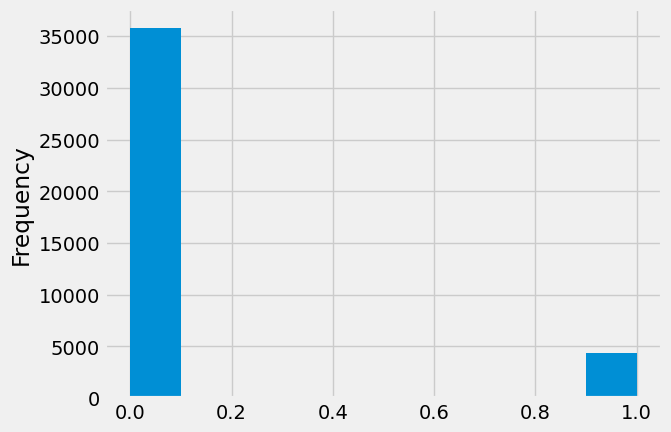

In [5]:
#Distribucion de la variable objetivo en train, observamos que claramente no es un dataset balanceado
train['target'].astype(int).plot.hist();

Es evidente que el dataset en cuanto a la variable objetivo esta desbalanceado pues tiene una proporcion 90/10

<Axes: xlabel='age', ylabel='total_cdt'>

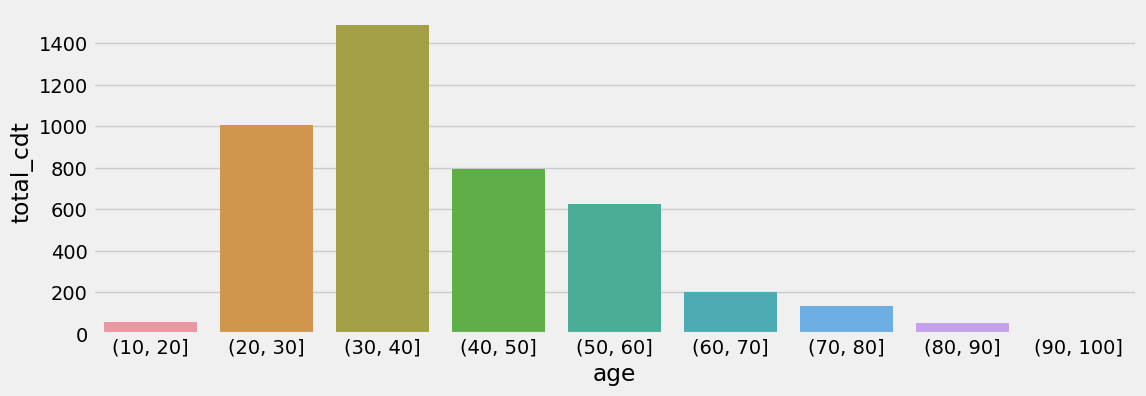

In [6]:
bins = [1,10,20,30,40,50,60,70,80,90,100]
categorias_edad = pd.cut(train.age,bins=bins).astype(str)
cdt_edad = train.loc[train.target==1].groupby(categorias_edad).agg(total_cdt=('target','count')).reset_index()
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(data=cdt_edad,x='age',y='total_cdt')

De esta grafica se puede deducir que los grupos de edades d las personas mas propensas a abrir un cdt se encuentran entre 20 a 40 años 

<Axes: xlabel='month', ylabel='total_cdt'>

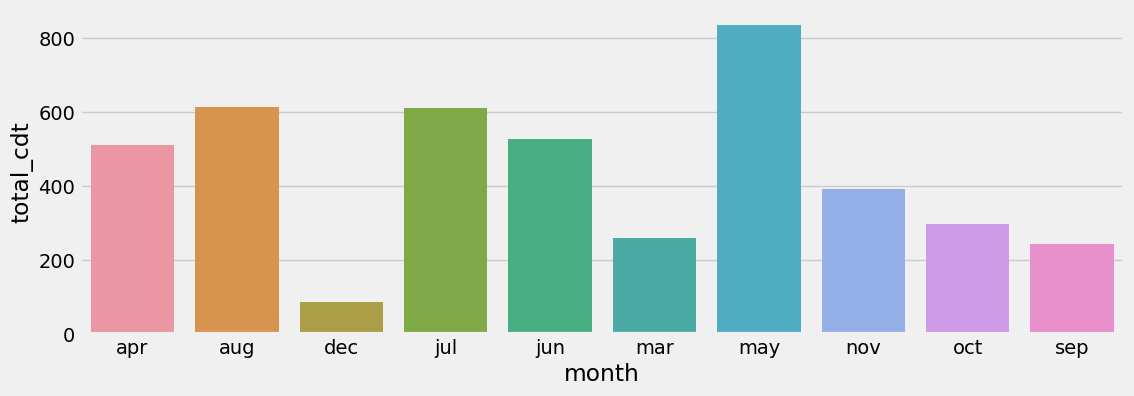

In [7]:
cdt_mes = train.loc[train.target==1].groupby("month").agg(total_cdt=('target','count')).reset_index()
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(data=cdt_mes,x='month',y='total_cdt')

Con esta grafica podemos ver que en el mes de mayo se abren mas cdts que en los demas meses. Contrario a diciembre, que tiene el menor numero de los meses presentados en la informacion 

In [8]:
train.groupby(['job'])["target"].mean()

job
admin.           0.125652
blue-collar      0.065479
entrepreneur     0.084507
housemaid        0.099222
management       0.105986
retired          0.244630
self-employed    0.098703
services         0.078846
student          0.305523
technician       0.104255
unemployed       0.136683
unknown          0.111111
Name: target, dtype: float64

Segun esta informacion las profesiones mas propensas a abrir un cdt seria los estudiantes en primer lugar, seguidos de los retirados y seguidos por los desempleados

In [9]:
train.groupby(['marital'])["target"].mean()

marital
divorced    0.099755
married     0.097893
single      0.134830
unknown     0.151899
Name: target, dtype: float64

Segun esta informacion los de estado civil solteros son mas proensos a abrir un cdt 

# Limpieza

In [10]:
#Unimos los dos dataframes para trabajarlos al mismo tiempo
train['dataset'] = 'train'
pred['dataset'] = 'pred'
# El ID único de cada cliente, por lo que lo vamos a setear como índice de cada dataframe
train.set_index('id', inplace=True)
pred.set_index('id', inplace=True)
# Unimos los dos df con append
train_pred = train.append(pred)  #Pegar algo por debajo 

train_pred.tail(1)

<ipython-input-10-7cc783c41be6>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_pred = train.append(pred)  #Pegar algo por debajo


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,target,dataset
id,,,,,,,,,,,,,,,,,,,,
39221,34,admin.,single,university.degree,no,no,no,cellular,mar,tue,1,6,1,success,-1.8,93.369,-34.8,5008.7,NaN,pred


In [11]:
#Para trabajar los unknown 
for columna in train_pred.columns: 
  train_pred.loc[train_pred[columna]=="unknown", columna]=np.nan

In [12]:
#Remplazar por la moda los nan 
for columna in train.columns:
  moda=train_pred[columna].mode()[0]
  train_pred.loc[train_pred[columna].isna(),columna]=moda

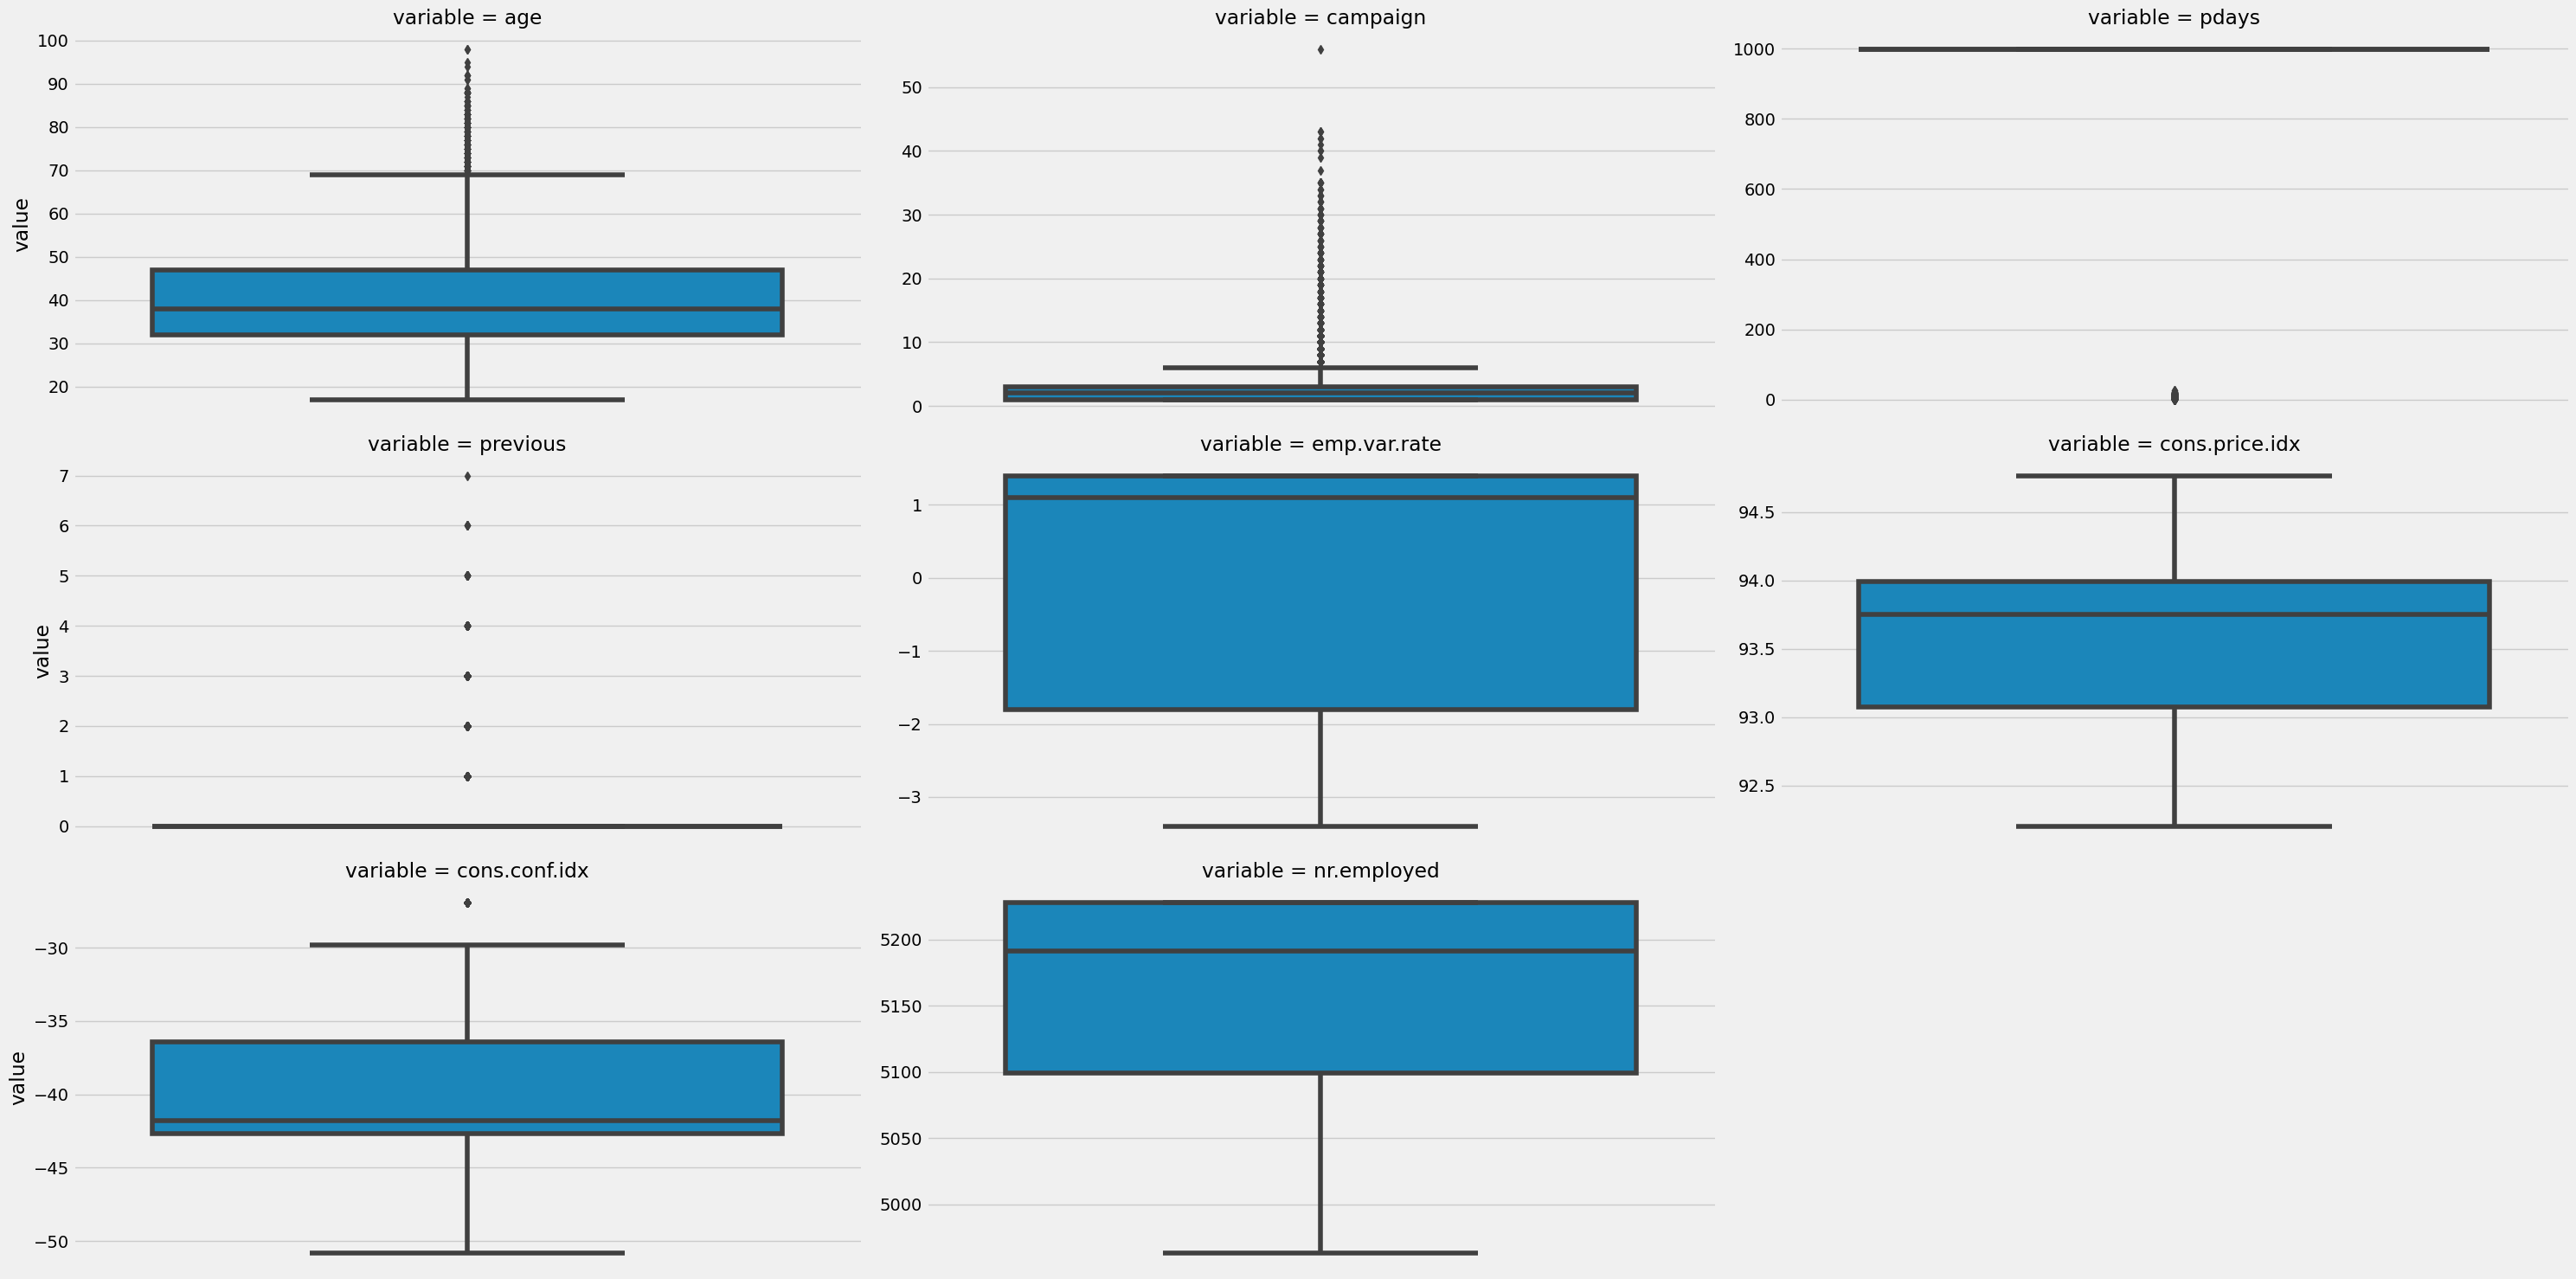

In [13]:
#Graficamos todas las variables numericas para identificar outliers 
columnas_num = ['age', 'campaign', 'pdays', 'previous',"emp.var.rate","cons.price.idx","cons.conf.idx","nr.employed"]
melt_num = pd.melt(train_pred.loc[:,train.columns.isin(columnas_num)],value_vars=columnas_num)
sns.catplot(data=melt_num,y='value',col='variable',col_wrap=3,kind='box',sharey=False,aspect=2)

Se graficaron las variables que contenian datos numericos, sin embargo,para muchas algunas de estas no tiene sentido modificar los outliers, como por ejemplo para pdays. Tambien es importante decir que hay algunas variables aqui que no aportan mucha informacion realmente valiosa

In [14]:
lista_col_outliers=['age', 'campaign',"emp.var.rate","cons.price.idx","cons.conf.idx","nr.employed"]

In [15]:
#Para modificar esos valores outliers 
for columna in lista_col_outliers:
    q1 = train_pred[columna].quantile(0.25)
    q3 = train_pred[columna].quantile(0.75)
    iqr = q3-q1 
    limite_arriba = q3 + 1.5*iqr
    limite_abajo = q1 - 1.5*iqr
    mediana = train_pred.loc[train_pred[columna]<q3 + 1.5*iqr, columna].median()
    media = train_pred[columna].mean()
    train_pred.loc[train_pred[columna] > limite_arriba,columna] = np.nan
    train_pred[columna].fillna(limite_arriba, inplace=True)
    train_pred.loc[train_pred[columna] < limite_abajo,columna] = np.nan
    train_pred[columna].fillna(limite_abajo, inplace=True) 

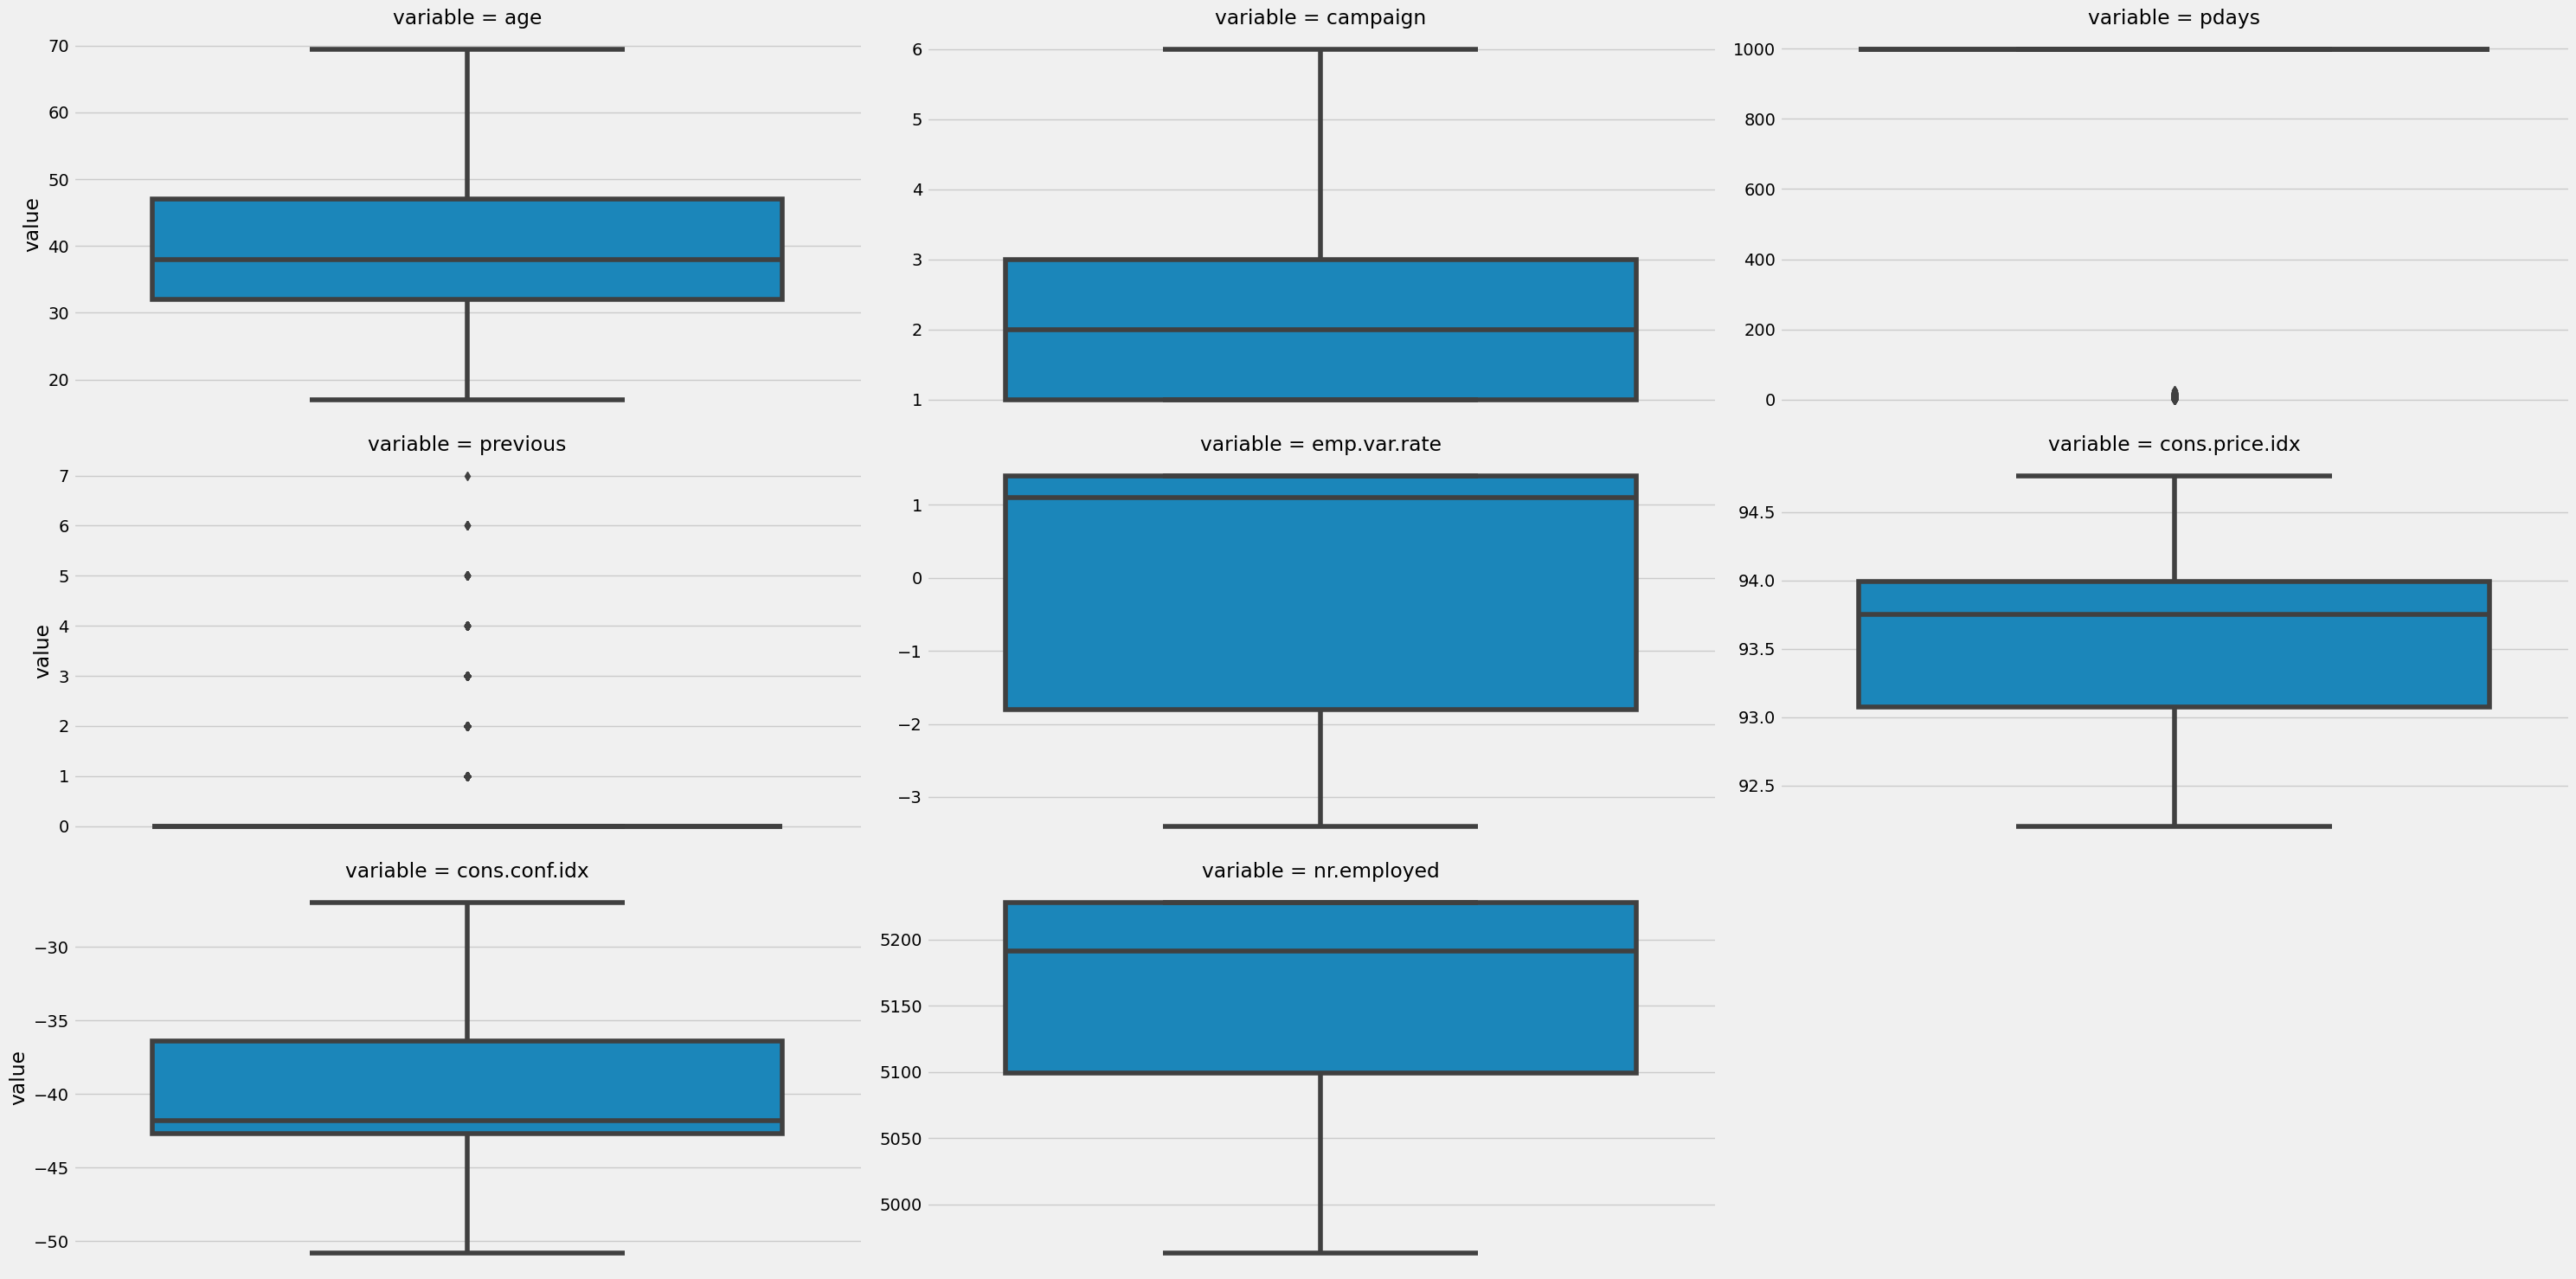

In [16]:
melt_num = pd.melt(train_pred.loc[:,train.columns.isin(columnas_num)],value_vars=columnas_num)
sns.catplot(data=melt_num,y='value',col='variable',col_wrap=3,kind='box',sharey=False,aspect=2)

Transformacion de variables categoricas

In [17]:
train_pred.education.value_counts()

university.degree      13899
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
illiterate                18
Name: education, dtype: int64

In [18]:
#Juntamos las categorias de educacion para que sean las concisas 
train_pred['education'] = train_pred['education'].replace(["basic.9y","basic.6y","basic.4y"],"Basica")
train_pred["education"] = train_pred['education'].replace(["university.degree","professional.course"],"Formal")
train_pred["education"] = train_pred['education'].replace(["high.school","illiterate"],"Bachiller")
train_pred.head(1)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,target,dataset
id,,,,,,,,,,,,,,,,,,,,
0,56.0,housemaid,married,Basica,no,no,no,telephone,may,mon,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,5191.0,0.0,train


In [19]:
#Juntamos las categorias de month porque tal vez asi aporten mas informacion valiosa 
train_pred['month'] = train_pred['month'].replace('mar', 'Primer_trimestre')
train_pred['month'] = train_pred['month'].replace(['apr', 'may', 'jun'], 'Segundo_trimestre')
train_pred['month'] = train_pred['month'].replace(['jul', 'aug', 'sep'], 'Tercer_trimestre')
train_pred['month'] = train_pred['month'].replace(['oct', 'nov', 'dec'], 'Cuarto_trimestre')

In [20]:
#Para transformar variables categoricas en numeros, para estas variables la jerarquia no importa 
le = LabelEncoder()
train_pred['marital'] = le.fit_transform(train_pred.marital)
train_pred['job'] = le.fit_transform(train_pred.job)
train_pred['month'] = le.fit_transform(train_pred.month)
train_pred.head(1)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,target,dataset
id,,,,,,,,,,,,,,,,,,,,
0,56.0,3,1,Basica,no,no,no,telephone,2,mon,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,5191.0,0.0,train


In [21]:
#El drop first es para que solo quede una columna porque la variable es binaria
train_pred["default"]=pd.get_dummies(train_pred.default,drop_first=True)
train_pred["housing"]=pd.get_dummies(train_pred.housing,drop_first=True)
train_pred["loan"]=pd.get_dummies(train_pred.loan,drop_first=True)
train_pred.head(1) 

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,target,dataset
id,,,,,,,,,,,,,,,,,,,,
0,56.0,3,1,Basica,0,0,0,telephone,2,mon,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,5191.0,0.0,train


In [45]:
# Eliminar variables no relevantes
col_eliminar = ['default','contact',"day_of_week","poutcome"]
train_pred= train_pred.loc[:,~train_pred.columns.isin(col_eliminar)]
train_pred.head(3)

,age,job,marital,education,housing,loan,month,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,target,dataset
id,,,,,,,,,,,,,,,
0,56.0,3,1,Basica,0,0,2,1.0,0.0,1.1,93.994,-36.4,5191.0,0.0,train
1,57.0,7,1,Bachiller,0,0,2,1.0,0.0,1.1,93.994,-36.4,5191.0,0.0,train
2,37.0,7,1,Bachiller,1,0,2,1.0,0.0,1.1,93.994,-36.4,5191.0,0.0,train


In [46]:
columnas_encodear = ['education']
train_pred_ohe = pd.get_dummies(train_pred, columns=columnas_encodear, prefix='OHE')
train_pred_ohe.head(2)

,age,job,marital,housing,loan,month,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,target,dataset,OHE_Bachiller,OHE_Basica,OHE_Formal
id,,,,,,,,,,,,,,,,,
0,56.0,3,1,0,0,2,1.0,0.0,1.1,93.994,-36.4,5191.0,0.0,train,0,1,0
1,57.0,7,1,0,0,2,1.0,0.0,1.1,93.994,-36.4,5191.0,0.0,train,1,0,0


# Hacemos el train y pred split

In [47]:
train_df = train_pred_ohe.loc[train_pred_ohe.dataset=='train',train_pred_ohe.columns!='dataset']
test_df = train_pred_ohe.loc[train_pred_ohe.dataset=='pred',train_pred_ohe.columns!='dataset']
train_df.head(1)

,age,job,marital,housing,loan,month,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,target,OHE_Bachiller,OHE_Basica,OHE_Formal
id,,,,,,,,,,,,,,,,
0,56.0,3,1,0,0,2,1.0,0.0,1.1,93.994,-36.4,5191.0,0.0,0,1,0


# Arbol de decision

In [48]:
x_train = pd.DataFrame(train_df.loc[:,train_df.columns!='target'])
y_train = pd.DataFrame(train_df.loc[:,"target"])

x_test = pd.DataFrame(test_df.loc[:,test_df.columns!='target'])
y_test = pd.DataFrame(test_df.loc[:,"target"])

In [49]:
print("Tamaño x train"+format(x_train.shape))
print("Tamaño y train"+format(y_train.shape))
print("Tamaño x test"+format(x_test.shape))
print("Tamaño y test"+format(y_test.shape))

Tamaño x train(40179, 15)
Tamaño y train(40179, 1)
Tamaño x test(1009, 15)
Tamaño y test(1009, 1)


In [116]:
modelo_arbol = DecisionTreeClassifier(max_depth = 10,random_state=15)
modelo_arbol.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=12, random_state=15)

In [117]:
scores = cross_val_score(modelo_arbol, x_train, y_train, cv = 8, scoring='accuracy')
scores.mean()

0.6842232570082043

Aqui usamos la metrica de accuracy porque con f1 nos dan resultados de 0,06 :( lo cual no tiene mucho sentido en si mismo

In [118]:
pred_arbol=pd.DataFrame(modelo_arbol.predict(x_test),columns=["target"],index=x_test.index).reset_index()
pred_arbol.target=pred_arbol.target.astype(int)

In [119]:
#Importamos la prediccion para subirla a kaggle
pred_arbol.to_csv("prediccion_1.csv",index=False)
files.download("prediccion_1.csv")
                    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Esta prediccion en Kaggle me dio valores al rededor de 71.  

# Random Forest

In [106]:
modelo_rf=RandomForestClassifier(n_estimators=200,random_state=44, min_samples_leaf=100, min_samples_split=200,max_depth=8, max_features=4)
modelo_rf.fit(x_train,y_train)
scores = cross_val_score(modelo_rf, x_train, y_train, cv = 8, scoring='accuracy')
print(scores.mean());

<ipython-input-106-80e8df2c05e7>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(x_train,y_train)
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

0.7495103021917577


In [107]:
pred_arbol_pod = pd.DataFrame(modelo_rf.predict(x_test),columns=['target'],index=test_df.index).reset_index()
pred_arbol_pod.target = pred_arbol_pod.target.astype(int)

In [108]:
pred_arbol_pod.to_csv("prediccion_2.csv",index=False)
files.download("prediccion_2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Esta prediccion en Kaggel esta dando en promedio 61

# Regresion logistica

In [57]:
scaler = MinMaxScaler()
train_norm = train_pred_ohe.loc[train_pred_ohe.dataset=='train',~train_pred_ohe.columns.isin(['dataset','target'])]
train_norm = pd.DataFrame(scaler.fit_transform(train_norm),index=train_norm.index,
                      columns=train_norm.columns)

test_norm = train_pred_ohe.loc[train_pred_ohe.dataset=='pred',~train_pred_ohe.columns.isin(['dataset','target'])]
test_norm = pd.DataFrame(scaler.fit_transform(test_norm),index=test_norm.index,
                      columns=test_norm.columns)

In [58]:
X = train_norm.loc[:,train_norm.columns!='target']
y = train_df["target"]

X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X, y, test_size= 0.3, random_state=42)

In [110]:
reg_log = linear_model.LogisticRegression(max_iter=100)
reg_log.fit(train_norm, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [111]:
pred_rl = pd.DataFrame(reg_log.predict(test_norm),columns=["target"],index=test_norm.index).reset_index()
pred_rl.target = pred_rl.target.astype(int)

In [114]:
# obtener accuracy para el modelo con las variables más importantes
acc_train_imp=accuracy_score(y_train_norm,reg_log.predict(X_train_norm))

acc_test_imp=accuracy_score(y_test_norm,reg_log.predict(X_test_norm))

print("Train:"+format(acc_train_imp))
print("Test:"+format(acc_test_imp))


Train:0.8937955555555556
Test:0.8945578231292517


In [113]:
pred_rl.to_csv("prediccion_3.csv",index=False)
files.download("prediccion_3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Esta prediccion en Kaggle esta dando un valor promedio de 55. Hay un claro y marcado desfase entre los resultados 

In [63]:
# Función para calcular la importancia de cada variable en el modelo
def get_feature_importance(clf):
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(14,25))
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_xticks([])
    featax.set_yticklabels(np.array(x_train.columns)[sorted_idx], fontsize=12)
    featax.set_xlabel('Relative Feature Importance', fontsize=15)

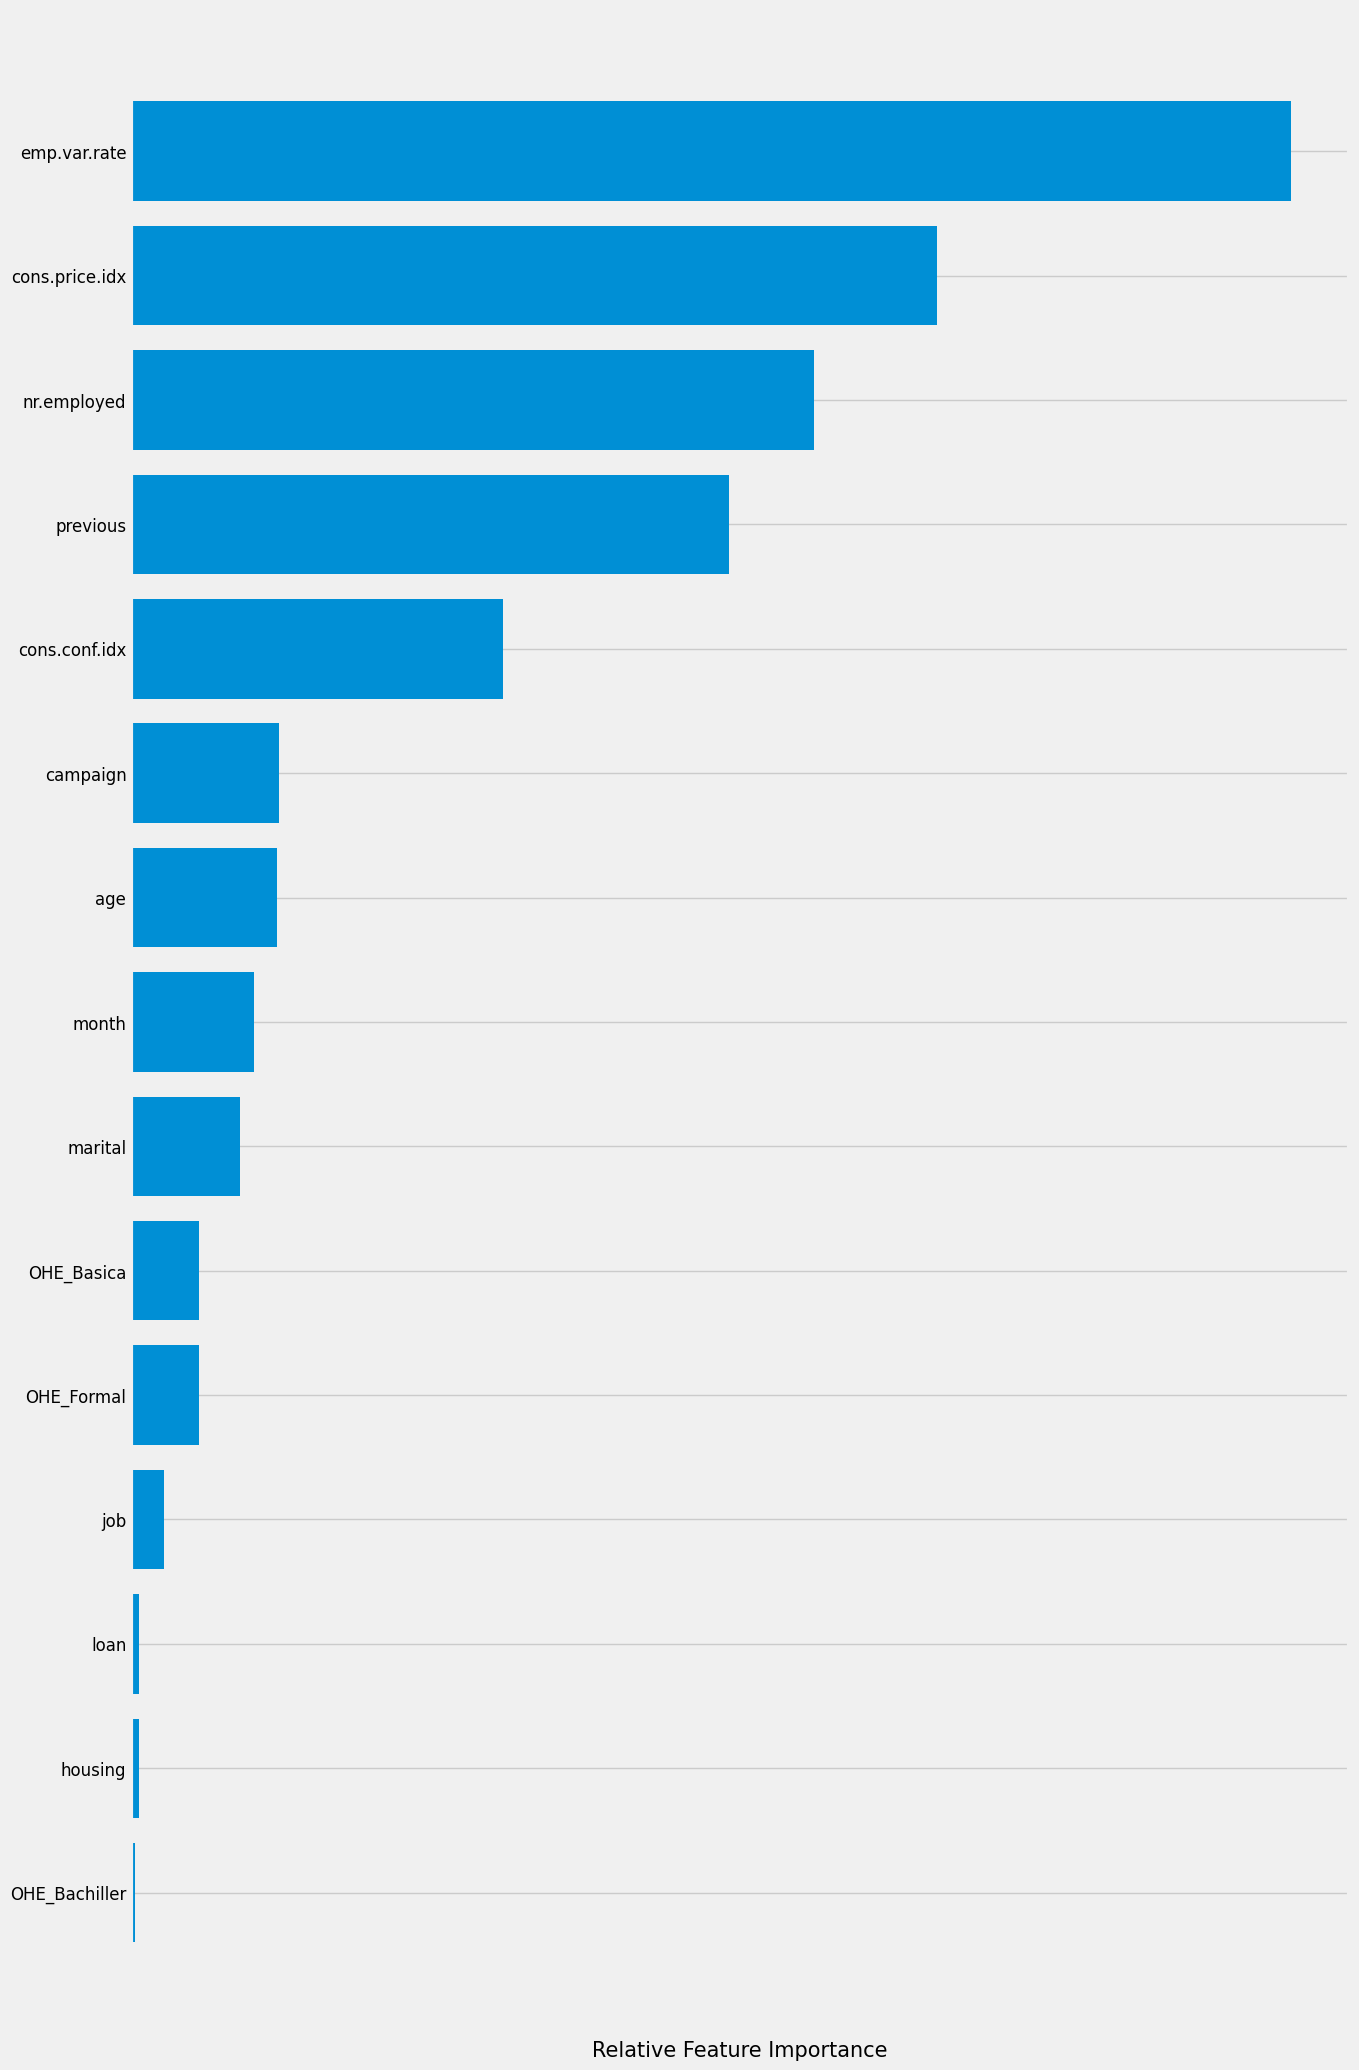

In [64]:
#obtener la importancia de cada variable 
get_feature_importance(reg_log)

De esta funcion se puede interpretar que las cuatro variables mas relevantes para predecir la variable objetivo son emp.var.rate, cons.price.idx, nr.employed y previous

In [115]:
# Función para generar la matriz de confusión
def plot_confusion_matrix_model(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes.tolist(), rotation=45)
    plt.yticks(tick_marks, classes.tolist())
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

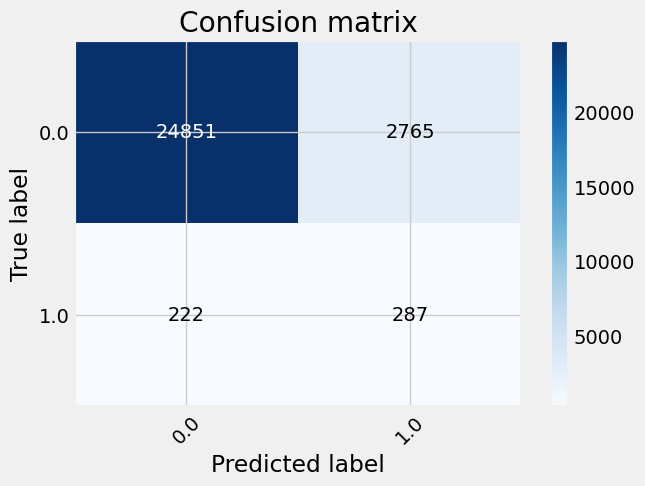

In [66]:
# generar predicciones
pred_train=pd.DataFrame(reg_log.predict(X_train_norm),columns=["Prediccion"])
# generar matriz de confusión
matriz_confusion=confusion_matrix(pred_train,y_train_norm)
plot_confusion_matrix_model(matriz_confusion,pred_train.Prediccion.sort_values().unique(),cmap=plt.cm.Blues)

Los valores de la diagonal principal a=2451 y d=287 corresponden a los valores estimados de forma correcta por el modelo, tanto los verdaderos positivos como los verdaderos negativos. Por otro lado, los valores de la otra diagona b=2765 y c=222 corresponden a los valores predecidos incorrectamente por el modelo; tanto los falsos positivos, como los falsos negativos